In [54]:
#Import libraries
import pandas as pd
import numpy as np

#Data Management
import joblib

#Training
import xgboost as xgb

# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler

#Visualization
import matplotlib.pyplot as plt


In [55]:
df = joblib.load('data/df_processed_3.pkl')

In [56]:
df.drop(columns=['id'],inplace=True)

target = df.pop('price')

In [59]:
df.head()

,host_location,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,...,Pets allowed,amenities_count,verification_email,verification_phone,verification_facebook,verification_reviews,verification_government_id,verification_selfie,distance,property_size
0,0,0,40.0,0,12,0.0,0.0,1,1,86,...,False,13,True,True,True,True,True,False,4.633575,28.0
1,1,3,97.0,1,3,8.0,8.0,1,1,53,...,False,31,True,True,False,True,True,False,3.533473,30.0
2,1,2,100.0,0,7,1.0,1.0,1,1,66,...,False,19,True,True,True,True,True,False,3.696110,68.0
3,0,1,75.0,0,9,1.0,1.0,1,0,74,...,False,24,True,True,False,True,True,False,3.755653,26.0
4,0,3,100.0,0,1,1.0,1.0,1,1,22,...,False,22,True,True,True,True,True,False,3.565951,63.0


In [67]:
# split our data
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2)


In [68]:
# scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [69]:
# create a baseline
booster = xgb.XGBRegressor()

In [72]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

param_grid_2 = {'n_estimators': [200,400,800],
              'learning_rate': [0.05], 
              'max_depth': [7,8,12,16],
              'colsample_bytree': [0.6],
              'gamma': [0.0]}


# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid_2, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400}


First GridSearch results: {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}

Second GridSearch results: {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400}


In [75]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, 
                           max_depth=6, n_estimators=400, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [76]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 26.2054


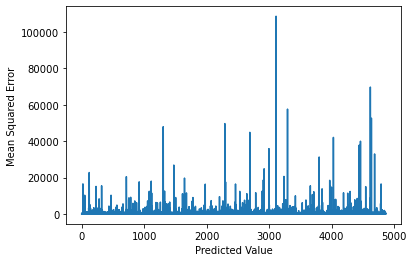

In [96]:
errors = []
y_pred_test = pd.DataFrame(y_pred_test)
for i in range(len(y_test)):
    # calculate error
    err = (y_test.iloc[i] - y_pred_test.iloc[i])**2
    # store error
    errors.append(err)
    # report error
    #print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))

# plot errors
plt.plot(errors)
#plt.xticks(ticks=[i for i in range(len(errors))], labels=y_pred_test)
plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.show()

In [77]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6808


In [92]:
y_pred_test.iloc[0]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

Text(0.5, 1.0, 'Feature Importance of top 20')

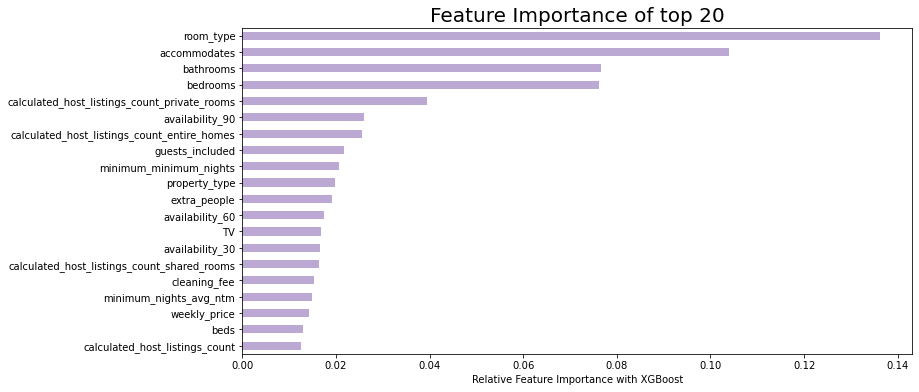

In [85]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=df.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh',  color='#7953a9', alpha=0.5, figsize=(12,6))
plt.xlabel('Relative Feature Importance with XGBoost');
plt.title('Feature Importance of top 20', fontsize=20)